<a href="https://colab.research.google.com/github/alviyandriadillah/Machine-Learning/blob/main/Sequence_to_Sequence_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install mxnet

In [1]:
pip install d2l

In [3]:
import collections
import math
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn, rnn
from d2l import mxnet as d2l

npx.set_np()

#**Encoder**

In [4]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.GRU(num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.swapaxes(0, 1)
        state = self.rnn.begin_state(batch_size=X.shape[1], ctx=X.ctx)
        output, state = self.rnn(X, state)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state[0]` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [5]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.initialize()
X = np.zeros((4, 7))
output, state = encoder(X)
output.shape

(7, 4, 16)

In [6]:
len(state), state[0].shape

(1, (2, 4, 16))

#**Decoder**

In [7]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.GRU(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).swapaxes(0, 1)
        # `context` shape: (`batch_size`, `num_hiddens`)
        context = state[0][-1]
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = np.broadcast_to(context, (
            X.shape[0], context.shape[0], context.shape[1]))
        X_and_context = np.concatenate((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).swapaxes(0, 1)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state[0]` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [8]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.initialize()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, len(state), state[0].shape

((4, 7, 10), 1, (2, 4, 16))

#**Loss Function**

In [9]:
X = np.array([[1, 2, 3], [4, 5, 6]])
npx.sequence_mask(X, np.array([1, 2]), True, axis=1)

array([[1., 0., 0.],
       [4., 5., 0.]])

In [10]:
X = np.ones((2, 3, 4))
npx.sequence_mask(X, np.array([1, 2]), True, value=-1, axis=1)

array([[[ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.]]])

In [11]:
#@save
class MaskedSoftmaxCELoss(gluon.loss.SoftmaxCELoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        # `weights` shape: (`batch_size`, `num_steps`, 1)
        weights = np.expand_dims(np.ones_like(label), axis=-1)
        weights = npx.sequence_mask(weights, valid_len, True, axis=1)
        return super(MaskedSoftmaxCELoss, self).forward(pred, label, weights)

In [12]:
loss = MaskedSoftmaxCELoss()
loss(np.ones((3, 4, 10)), np.ones((3, 4)), np.array([4, 2, 0]))

array([2.302588, 1.151294, 0.      ])

#**Training**

In [13]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    net.initialize(init.Xavier(), force_reinit=True, ctx=device)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    loss = MaskedSoftmaxCELoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [
                x.as_in_ctx(device) for x in batch]
            bos = np.array(
                [tgt_vocab['<bos>']] * Y.shape[0], ctx=device).reshape(-1, 1)
            dec_input = np.concatenate([bos, Y[:, :-1]], 1)  # Teacher forcing
            with autograd.record():
                Y_hat, _ = net(X, dec_input, X_valid_len)
                l = loss(Y_hat, Y, Y_valid_len)
            l.backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            trainer.step(num_tokens)
            metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

In [14]:
pip uninstall matplotlib

Found existing installation: matplotlib 3.3.3
Uninstalling matplotlib-3.3.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.3


In [15]:
pip install matplotlib

     |████████████████████████████████| 11.2 MB 7.4 MB/s 
     |████████████████████████████████| 890 kB 56.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.5.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


loss 0.019, 5090.9 tokens/sec on cpu(0)


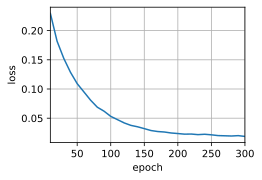

In [16]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

#**Prediction**

In [17]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = np.array([len(src_tokens)], ctx=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = np.expand_dims(np.array(src_tokens, ctx=device), axis=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = np.expand_dims(np.array([tgt_vocab['<bos>']], ctx=device), axis=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(axis=2)
        pred = dec_X.squeeze(axis=0).astype('int32').item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

#**Evaluation of Predicted Sequences**

In [18]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [19]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => sois malade ., bleu 0.000
i'm home . => je suis sûr ., bleu 0.512
